In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**RESNET50 MURA UCD**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.io as io
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torchvision.transforms.functional import to_pil_image
# ===============================
# Configuración
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando {device}")

IMG_SIZE = 224
NUM_CLASSES = 14
BATCH_SIZE = 64
EPOCHS_FROZEN = 40
EPOCHS_UNFROZEN = 40
LR_FROZEN = 1e-4
LR_UNFROZEN = 1e-6

CHECKPOINT_PATH = "/content/drive/MyDrive/TESIS/MURA_UCD/checkpoint_resnet50.pth"

# ===============================
# Transformaciones (data aug)
# ===============================
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

valid_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# ===============================
# Dataset desde CSV
# ===============================
class FractureDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        df = pd.read_csv(csv_path)
        # Filtrar solo los que existen
        df["ruta"] = df["ruta"].str.replace("\\", "/")  # por si viene con \ de Windows
        df = df[df["ruta"].apply(os.path.exists)]
        self.df = df.reset_index(drop=True)
        self.transform = transform


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['ruta']
        label = int(self.df.iloc[idx]['clase'])

        img = io.read_image(path).float() / 255.0

        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)

        img = to_pil_image(img)

        if self.transform:
            img = self.transform(img)

        return img.to(device), torch.tensor(label, dtype=torch.long, device=device)

# ===============================
# Datos
# ===============================
train_csv = "/content/train_multiclase_UCD.csv"
valid_csv = "/content/valid_multiclase_UCD.csv"

train_dataset = FractureDataset(train_csv, transform=train_transforms)
valid_dataset = FractureDataset(valid_csv, transform=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ===============================
# Pesos de clase
# ===============================
y_train = pd.read_csv(train_csv)["clase"].values
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# ===============================
# Modelo ResNet50
# ===============================
model = models.resnet50(weights="IMAGENET1K_V1")
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES)
)
model = model.to(device)

# ===============================
# Checkpoint
# ===============================
def save_checkpoint(model, optimizer, epoch, path="CHECKPOINT_PATH"):
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch
    }, path)
    print(f"Checkpoint guardado (época {epoch})")

def load_checkpoint(model, optimizer, path="CHECKPOINT_PATH"):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print(f" Checkpoint cargado desde época {checkpoint['epoch'] + 1}")
        return checkpoint["epoch"] + 1
    return 0

# ===============================
# Entrenamiento
# ===============================
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
scaler = torch.cuda.amp.GradScaler()

# Congelar capas base
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=LR_FROZEN)
start_epoch = load_checkpoint(model, optimizer)

print("\n Iniciando entrenamiento...")
for epoch in range(start_epoch, EPOCHS_FROZEN + EPOCHS_UNFROZEN):

    # Descongelar para fine-tuning
    if epoch == EPOCHS_FROZEN:
        print("Cambiando a fase 2: fine-tuning completo")
        for param in model.parameters():
            param.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=LR_UNFROZEN)

    model.train()
    total, correct, loss_total = 0, 0, 0
    fase = "F1" if epoch < EPOCHS_FROZEN else "F2"
    loop = tqdm(train_loader, desc=f"{fase} Epoch {epoch+1}")

    for images, labels in loop:
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loss_total += loss.item()
        loop.set_postfix(loss=loss_total / len(train_loader), acc=correct / total)

    save_checkpoint(model, optimizer, epoch)

# ===============================
# Guardar modelo final
# ===============================
torch.save(model.state_dict(), "/content/drive/MyDrive/TESIS/MURA_UCD/resnet50_multiclaseUCD.pth")
print("✅ Modelo final guardado como resnet50_multiclaseUCD.pth")


✅ Usando cuda


<ipython-input-19-839170fea285>:136: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


 Checkpoint cargado desde época 80

 Iniciando entrenamiento...
✅ Modelo final guardado como resnet50_multiclaseUCD.pth


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
from IPython.display import display

NUM_CLASSES = 14
class_names = [f"Clase {i}" for i in range(NUM_CLASSES)]

report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

# Convertir a DataFrame y redondear
df_metrics = pd.DataFrame(report_dict).transpose().round(3)

# Mostrar en consola como tabla completa
print("📋 Reporte de Clasificación:")
print(df_metrics.to_string())

# Mostrar como tabla interactiva
print("\n📊 Vista interactiva en notebook:")
display(df_metrics)

# Guardar y Excel
df_metrics.to_excel("/content/metricas_RES.xlsx")

print(" Métricas guardadas en:")
print("   - /content/metricas_RES.xlsx")


📋 Reporte de Clasificación:
              precision  recall  f1-score   support
Clase 0           0.723   0.760     0.741   905.000
Clase 1           0.752   0.696     0.723   905.000
Clase 2           0.800   0.784     0.792   601.000
Clase 3           0.728   0.730     0.729   463.000
Clase 4           0.755   0.736     0.746   621.000
Clase 5           0.643   0.684     0.663   437.000
Clase 6           0.754   0.812     0.782   276.000
Clase 7           0.559   0.676     0.612   148.000
Clase 8           0.849   0.725     0.782   932.000
Clase 9           0.448   0.653     0.532   326.000
Clase 10          0.796   0.760     0.778   175.000
Clase 11          0.711   0.720     0.715   150.000
Clase 12          0.795   0.854     0.823  1239.000
Clase 13          0.787   0.662     0.719   822.000
accuracy          0.742   0.742     0.742     0.742
macro avg         0.722   0.732     0.724  8000.000
weighted avg      0.751   0.742     0.744  8000.000

📊 Vista interactiva en notebook:


,precision,recall,f1-score,support
Clase 0,0.723,0.760,0.741,905.000
Clase 1,0.752,0.696,0.723,905.000
Clase 2,0.800,0.784,0.792,601.000
Clase 3,0.728,0.730,0.729,463.000
Clase 4,0.755,0.736,0.746,621.000
Clase 5,0.643,0.684,0.663,437.000
Clase 6,0.754,0.812,0.782,276.000
Clase 7,0.559,0.676,0.612,148.000
Clase 8,0.849,0.725,0.782,932.000
Clase 9,0.448,0.653,0.532,326.000


 Métricas guardadas en:
   - /content/metricas_RES.xlsx


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np
import os

# Configuraciones
NUM_CLASSES = 14
class_names = [f"Clase {i}" for i in range(NUM_CLASSES)]
save_path = "/content/curvas_roc_clases"

# Crear carpeta si no existe
os.makedirs(save_path, exist_ok=True)

# Binarizar etiquetas reales
y_true_bin = label_binarize(all_labels, classes=list(range(NUM_CLASSES)))
y_score = np.array(all_probs)

# Una curva por clase
for i in range(NUM_CLASSES):
    try:
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
        plt.plot([0, 1], [0, 1], "k--", lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("Tasa de Falsos Positivos (FPR)")
        plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
        plt.title(f"📈 Curva ROC - {class_names[i]}")
        plt.legend(loc="lower right")
        plt.grid(True)

        # Guardar curva
        file_path = os.path.join(save_path, f"roc_clase_{i}.png")
        plt.savefig(file_path)
        plt.close()
        print(f" Guardada curva ROC: {file_path}")

    except ValueError:
        print(f" No se pudo calcular curva ROC para {class_names[i]} (clase vacía)")



<ipython-input-22-6632daca6922>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)
<ipython-input-22-6632daca6922>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)


 Guardada curva ROC: /content/curvas_roc_clases/roc_clase_0.png
 Guardada curva ROC: /content/curvas_roc_clases/roc_clase_1.png


<ipython-input-22-6632daca6922>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)
<ipython-input-22-6632daca6922>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)


 Guardada curva ROC: /content/curvas_roc_clases/roc_clase_2.png
 Guardada curva ROC: /content/curvas_roc_clases/roc_clase_3.png


<ipython-input-22-6632daca6922>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)
<ipython-input-22-6632daca6922>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)


 Guardada curva ROC: /content/curvas_roc_clases/roc_clase_4.png
 Guardada curva ROC: /content/curvas_roc_clases/roc_clase_5.png


<ipython-input-22-6632daca6922>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)
<ipython-input-22-6632daca6922>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)


 Guardada curva ROC: /content/curvas_roc_clases/roc_clase_6.png
 Guardada curva ROC: /content/curvas_roc_clases/roc_clase_7.png


<ipython-input-22-6632daca6922>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)
<ipython-input-22-6632daca6922>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)


 Guardada curva ROC: /content/curvas_roc_clases/roc_clase_8.png
 Guardada curva ROC: /content/curvas_roc_clases/roc_clase_9.png


<ipython-input-22-6632daca6922>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)
<ipython-input-22-6632daca6922>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)


 Guardada curva ROC: /content/curvas_roc_clases/roc_clase_10.png
 Guardada curva ROC: /content/curvas_roc_clases/roc_clase_11.png
 Guardada curva ROC: /content/curvas_roc_clases/roc_clase_12.png
 Guardada curva ROC: /content/curvas_roc_clases/roc_clase_13.png


<ipython-input-22-6632daca6922>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)
<ipython-input-22-6632daca6922>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)


<ipython-input-23-31b2c4c5e45b>:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


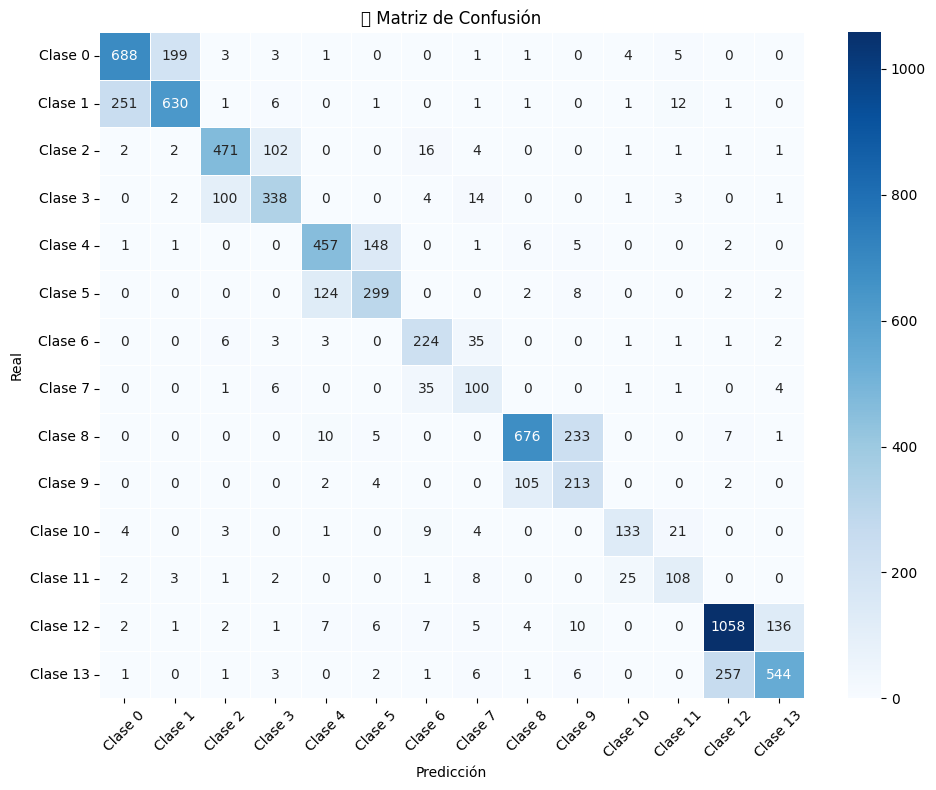

✅ Matriz de confusión guardada como matriz_confusion.csv


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# 2. Crear etiquetas si no las tenés
class_names = [f"Clase {i}" for i in range(NUM_CLASSES)]

# 3. Convertir a DataFrame para visualización y guardado
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
df_cm.index.name = "Real"
df_cm.columns.name = "Predicho"

# 4. Mostrar visualmente la matriz
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("📊 Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Guardar como CSV
df_cm.to_csv("/content/matriz_confusion.csv")
print("✅ Matriz de confusión guardada como matriz_confusion.csv")
